In [200]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

class Household(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, inability=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.inability = inability
        self.savings = 0  # savings is initialized as 0
        self.arrears = 0

    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling)
        
    def step(self):
        """Update the agent's savings in a step."""
        # Calculate energy costs
        energy_costs = self.energy_cost

        # Check if the agent is in arrears
        if energy_costs > self.disposable_income * 0.3:  # now considering arrears if energy cost exceeds 60% of disposable income
            self.arrears += energy_costs
        else:
            self.savings += self.disposable_income - energy_costs

        # If the agent has arrears
        if self.arrears > 0:
            if self.savings >= self.arrears:  # and if savings can cover it
                self.savings -= self.arrears
                self.arrears = 0
            else:  # if savings cannot cover it
                self.arrears = self.arrears - self.savings  # set arrears to remaining amount
                self.savings = 0

        self.inability = self.energy_cost > self.disposable_income * 0.1  # agent is in inability state if energy costs exceed 10% of income

        # Update disposable income based on growth rate
        growth_rate = np.random.uniform(self.model.growth_boundaries[0], self.model.growth_boundaries[1])
        self.disposable_income *= (1 + growth_rate)


class Country(Model):
    
    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        raise Exception(f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}")
    
    @staticmethod
    def assign_inability(agents, inability_start):
        """
        Assigns the inability to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_unable = int(inability_start * num_agents)
        inability_per_quintile = np.array([2, 1.6, 1.2, 0.8, 0])
        inability_per_quintile *= num_unable / np.sum(inability_per_quintile)
        inability_per_quintile = inability_per_quintile.astype(int)

        assigned_unable = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_unable_quintile = min(inability_per_quintile[i], len(quintile))
            unable_agents = np.random.choice(quintile, num_unable_quintile, replace=False)
            for agent in unable_agents:
                agent.inability = True
            assigned_unable += num_unable_quintile

        # Assign remaining inability if any
        i = 0
        while assigned_unable < num_unable:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.inability]
            if quintile:
                agent = np.random.choice(quintile)
                agent.inability = True
                assigned_unable += 1
            else:
                i += 1

    @staticmethod
    def assign_dwelling(agents, energy_price):
        """
        Assigns the dwelling to the agents.
        """
        buffer = 0.02  # 2% buffer or margin
        all_incomes = [agent.disposable_income for agent in agents]
        quintile_thresholds = np.quantile(all_incomes, [0.2, 0.4])  # Calculate income thresholds for the bottom two quintiles
        for agent in agents:
            min_dwelling, max_dwelling = 500, 2000
            if agent.inability:
                min_dwelling = max(min_dwelling, int(np.ceil((agent.disposable_income * (0.1 + buffer)) / energy_price)))
            else:
                max_dwelling = min(max_dwelling, int((agent.disposable_income * (0.1 - buffer)) / energy_price))

            # Generate a list of feasible dwelling values
            feasible_dwelling = list(range(min_dwelling, max_dwelling + 1))

            # If the list is not empty, select a random dwelling from the list
            if feasible_dwelling:
                agent.dwelling = np.random.choice(feasible_dwelling)
            else:
                agent.dwelling = min_dwelling  # fallback to the min_dwelling if no other options

            # Check income quintile of the agent and if in inability state, increase dwelling size
            if agent.disposable_income < quintile_thresholds[1] and agent.inability:  # If in bottom two quintiles and inability is True
                agent.dwelling = min(max_dwelling, int(agent.dwelling * 1.25))  # Increase dwelling size by 25%, but not more than max_dwelling

    def __init__(self, N, median_income, min_disposal, gini_target, inability_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound):
        self.num_agents = N
        self.median_income = median_income
        self.min_disposal = min_disposal
        self.gini_target = gini_target
        self.inability_target = inability_target
        self.growth_boundaries = growth_boundaries
        self.prices = prices
        self.shares_p = shares_p
        self.growth_rate_lower_bound = growth_rate_lower_bound
        self.growth_rate_upper_bound = growth_rate_upper_bound
        # Other initialization code...
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
        agent_reporters={"Dwelling": "dwelling", 
                        "Income": "disposable_income",
                        "Inability": "inability",
                        "Savings":"savings",
                        "Arrears":"arrears",
                        "EnergyCost": "energy_cost"},
        model_reporters = {
                        "Inability Over Time": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents,
                        "Arrears Over Time": lambda model: sum(agent.arrears for agent in model.schedule.agents) / model.num_agents,
                        "Energy Price": lambda model: model.energy_price,
                        "Initial Energy Price": lambda model: model.initial_energy_price,
                        "Price 1": lambda model: model.prices[0],
                        "Price 2": lambda model: model.prices[1]
                        })

        # Generate disposable incomes and assign dwelling and technology
        incomes = self.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)

        self.initial_energy_price = np.dot(self.prices, self.shares_p)

 
        # Create agents
        agents = []
        for i in range(self.num_agents):
            a = Household(i, self, disposable_income=incomes[i], dwelling=0, inability=False)
            agents.append(a)

        
        self.assign_inability(agents, self.inability_target)
        self.assign_dwelling(agents, self.energy_price)

        # Add agents to the model
        for a in agents:
            self.schedule.add(a)

    @property
    def energy_price(self):
        """Calculate and return the current energy price."""
        return np.dot(self.prices, self.shares_p)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)  # Collect data before updating the prices

        # Update prices based on unique growth rates
        growth_rates = np.random.uniform(self.growth_rate_lower_bound, self.growth_rate_upper_bound)
        self.prices = np.maximum(0, self.prices * (1 + growth_rates))

        self.schedule.step()

In [201]:
# population, median_income, min_disposal, gini_target, inability_target, growth_boundaries:[], prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound

In [202]:

model = Country(1000, 1700, 900, 0.30, 0.2, [-0.02,0.02], np.array([0.2, 0.06]), np.array([0.5, 0.5]), np.array([-0.01, -0.01]), np.array([0.01, 0.01]) )

 
for i in range(84):
    model.step()


agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()


In [203]:
agent_data

Dwelling       Income  Inability        Savings  Arrears  \
Step AgentID                                                             
0    4             535   900.000000      False       0.000000      0.0   
     7             510   900.000000      False       0.000000      0.0   
     9            2000   900.000000       True       0.000000      0.0   
     13            529   900.000000      False       0.000000      0.0   
     20           1421   900.000000       True       0.000000      0.0   
...                ...          ...        ...            ...      ...   
83   533           955  6533.997617      False  527189.396853      0.0   
     998           753  7116.944440      False  559183.912478      0.0   
     749           533  8526.746839      False  672178.215836      0.0   
     114           947  7640.542623      False  659258.214845      0.0   
     939           978  8906.421424      False  716128.812750      0.0   

              EnergyCost  
Step AgentID              
0    4         69.550000  
     7         66.300000  
     9        260.000000  
     13        68.770000  
     20       184.730000  
...                  ...  
83   533      130.149841  
     998      102.620765  
     749       72.638602  
     114      129.059580  
     939      133.284340  

[84000 rows x 6 columns]

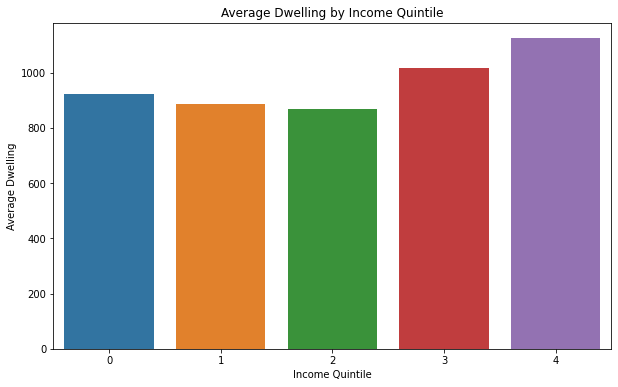

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'agent_df' is your DataFrame
agent_df = model.datacollector.get_agent_vars_dataframe()

# Calculate quintiles
agent_df['Income Quintile'] = pd.qcut(agent_df['Income'], 5, labels=False)

# Calculate average dwelling by income quintile
average_dwelling = agent_df.groupby('Income Quintile')['Dwelling'].mean().reset_index()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Quintile', y='Dwelling', data=average_dwelling)
plt.title('Average Dwelling by Income Quintile')
plt.xlabel('Income Quintile')
plt.ylabel('Average Dwelling')
plt.show()


In [205]:
import plotly.graph_objects as go

# Assume that `model` is the instance of your model
model_df = model.datacollector.get_model_vars_dataframe()

# Create a line plot
fig = go.Figure(data=go.Scatter(x=model_df.index, y=model_df['Inability Over Time'], mode='lines'))

# Set labels and title
fig.update_layout(title='Inability over time', xaxis_title='Time (steps)', yaxis_title='Inability share')

# Show plot
fig.show()


In [206]:
import plotly.graph_objects as go

# Assume that `model` is the instance of your model
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

# Model-level data
for col in model_df.columns:
    fig = go.Figure(data=go.Scatter(x=model_df.index, y=model_df[col], mode='lines'))
    fig.update_layout(title=f'{col} over time', xaxis_title='Time (steps)', yaxis_title=col)
    fig.show()

In [207]:
import plotly.graph_objects as go

# Assume that `model` is the instance of your model
model_df = model.datacollector.get_model_vars_dataframe()

fig = go.Figure()

# Add scatter plots for each price
for price in ['Energy Price', 'Price 1', 'Price 2']:
    fig.add_trace(go.Scatter(x=model_df.index, y=model_df[price], mode='lines', name=price))

# Set labels and title
fig.update_layout(title='Prices over time', xaxis_title='Time (steps)', yaxis_title='Price')

fig.show()

In [208]:
agent_data = model.datacollector.get_agent_vars_dataframe()
arrears_data = agent_data['Arrears']


In [209]:
import plotly.graph_objects as go

# Create a dataframe from the agent data
model_df = model.datacollector.get_model_vars_dataframe()

# Create a line plot for 'Arrears Over Time'
fig = go.Figure(data=go.Scatter(x=model_df.index, y=model_df['Arrears Over Time'], mode='lines'))

# Set labels and title
fig.update_layout(title='Arrears Over Time', xaxis_title='Time (steps)', yaxis_title='Arrears')

# Show plot
fig.show()


In [210]:
model_df['Arrears Over Time']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
79    122.128651
80    125.110819
81    128.094485
82    131.080571
83    134.078378
Name: Arrears Over Time, Length: 84, dtype: float64

In [211]:
# Fetch agent-level data
agent_df = model.datacollector.get_agent_vars_dataframe()

# Get data for steps 44 to 46
steps_44_to_46 = agent_df.xs(slice(44, 46), level="Step")

steps_44_to_46


,Dwelling,Income,Inability,Savings,Arrears,EnergyCost
AgentID,,,,,,
4,535,1074.036922,False,40130.429377,0.0,71.078559
7,510,818.047179,False,34377.217490,0.0,67.757131
9,2000,913.491600,True,18171.815882,0.0,265.714239
13,529,976.057629,False,37975.109839,0.0,70.281416
20,1421,831.637185,True,28980.953469,0.0,188.789967
...,...,...,...,...,...,...
533,955,6645.156284,False,290440.786710,0.0,127.930208
998,753,7136.827382,False,298958.887916,0.0,100.870625
749,533,8415.556438,False,357866.018970,0.0,71.399791


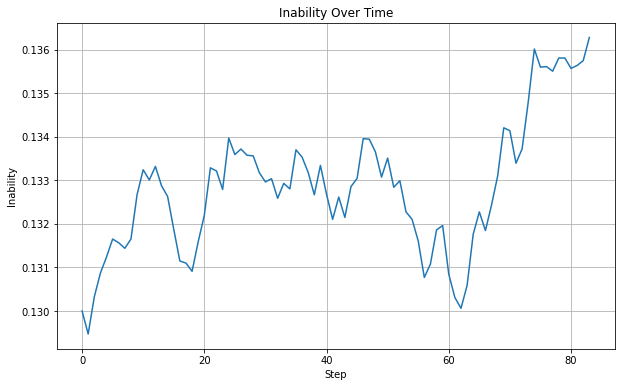

In [212]:
# After running the model
model_data = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(model_data['Energy Price'])
plt.xlabel('Step')
plt.ylabel('Inability')
plt.title('Inability Over Time')
plt.grid(True)
plt.show()

In [213]:
model_data['Inability Over Time']

0     0.200
1     0.200
2     0.200
3     0.200
4     0.200
      ...  
79    0.205
80    0.205
81    0.205
82    0.205
83    0.205
Name: Inability Over Time, Length: 84, dtype: float64

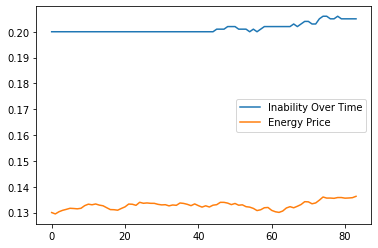

In [214]:
model_data[["Inability Over Time", "Energy Price"]].plot()
plt.show()


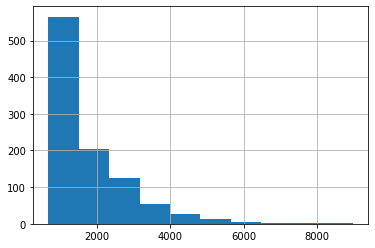

In [215]:
agent_data.xs(80, level="Step")["Income"].hist()
plt.show()


In [216]:
### RES implementation: 

In [217]:
# from mesa import Agent, Model
# from mesa.time import RandomActivation
# from mesa.datacollection import DataCollector
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import pandas as pd

# class Household(Agent):
#     # ... existing code ...

#     def step(self):
#         """Update the agent's savings in a step."""
#         # Calculate energy costs
#         energy_costs = self.energy_cost

#         # Check if the agent is in arrears
#         if energy_costs > self.disposable_income * 0.6:
#             self.arrears += energy_costs  # add the energy costs to arrears
#             self.savings -= self.arrears  # adjust savings by the amount of arrears
#         else:
#             self.savings += self.disposable_income - energy_costs

#         # If the agent has arrears and enough savings to pay it off
#         if self.arrears > 0 and self.savings >= self.arrears:
#             self.savings -= self.arrears
#             self.arrears = 0
#         elif self.arrears > 0 and self.savings < self.arrears:
#             self.arrears -= self.savings
#             self.savings = 0

#         self.inability = self.arrears > 0  # agent is in inability state if it has arrears

#         # Update disposable income based on growth rate
#         growth_rate = np.random.uniform(self.model.growth_boundaries[0], self.model.growth_boundaries[1])
#         self.disposable_income *= (1 + growth_rate)

# class Country(Model):
#     # ... existing code ...

#     def __init__(self, N, median_income, min_disposal, gini_target, inability_target, growth_boundaries, prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound, RES_share):
#         self.num_agents = N
#         self.median_income = median_income
#         self.min_disposal = min_disposal
#         self.gini_target = gini_target
#         self.inability_target = inability_target
#         self.growth_boundaries = growth_boundaries
#         self.prices = prices
#         self.shares_p = shares_p
#         self.growth_rate_lower_bound = growth_rate_lower_bound
#         self.growth_rate_upper_bound = growth_rate_upper_bound
#         self.RES_share = RES_share  # initial RES share
#         # Other initialization code...

#     # ... existing code ...

#     def step(self):
#         """Advance the model by one step."""
#         self.datacollector.collect(self)  # Collect data before updating the prices

#         # Update prices based on unique growth rates
#         growth_rates = np.random.uniform(self.growth_rate_lower_bound, self.growth_rate_upper_bound)
#         self.prices = np.maximum(0, self.prices * (1 + growth_rates))

#         # Update RES share and adjust Price 1
#         increase_in_res_share = # calculate the increase in RES_share
#         self.RES_share += increase_in_res_share
#         self.prices[0] *= (1 - 0.002 * increase_in_res_share)  # decrease Price 1
#         self.prices[0] = max(self.prices[0], 0)  # ensure Price 1 can't be negative

#         self.schedule.step()
